In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import xgboost as xgb


In [2]:
#read in data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


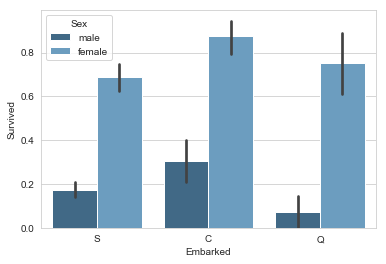

In [4]:
sns.barplot(x= 'Embarked', y= 'Survived', hue='Sex', data = df_train,palette='Blues_d') 
#Looks like more females survived than males
#Also passengers embarking from C were more likely to Survive 

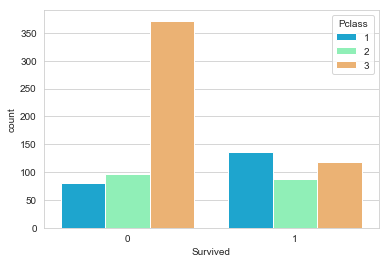

In [5]:
sns.countplot(x='Survived',hue='Pclass',data=df_train,palette='rainbow')
#majority of Passenger Class 1 survived while majority of passenger class 3 did not survive

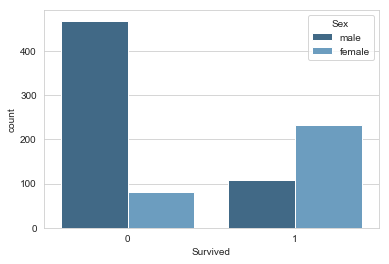

In [6]:
sns.countplot(x= 'Survived', hue='Sex', data = df_train,palette="Blues_d")
#females were more likely to survive, males vice versa


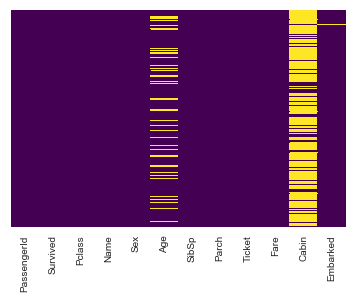

In [7]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#missing data for Age and Cabin

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

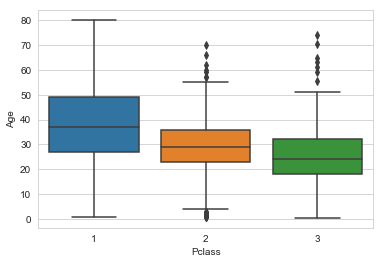

In [8]:
#Need to find the average age by sex and pclass
sns.boxplot(x='Pclass',y='Age',data=df_train)
df_train.groupby(['Pclass','Sex']).Age.mean()

In [9]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    Sex = cols[2]
    if pd.isnull(Age):
        if Sex == 'male':
            if Pclass == 1:
                return 41
            elif Pclass == 2:
                return 31
            else:
                return 27
        elif Sex == 'female':
            if Pclass == 1:
                return 35
            elif Pclass == 2:
                return 29
            else:
                return 22
    else:
        return Age

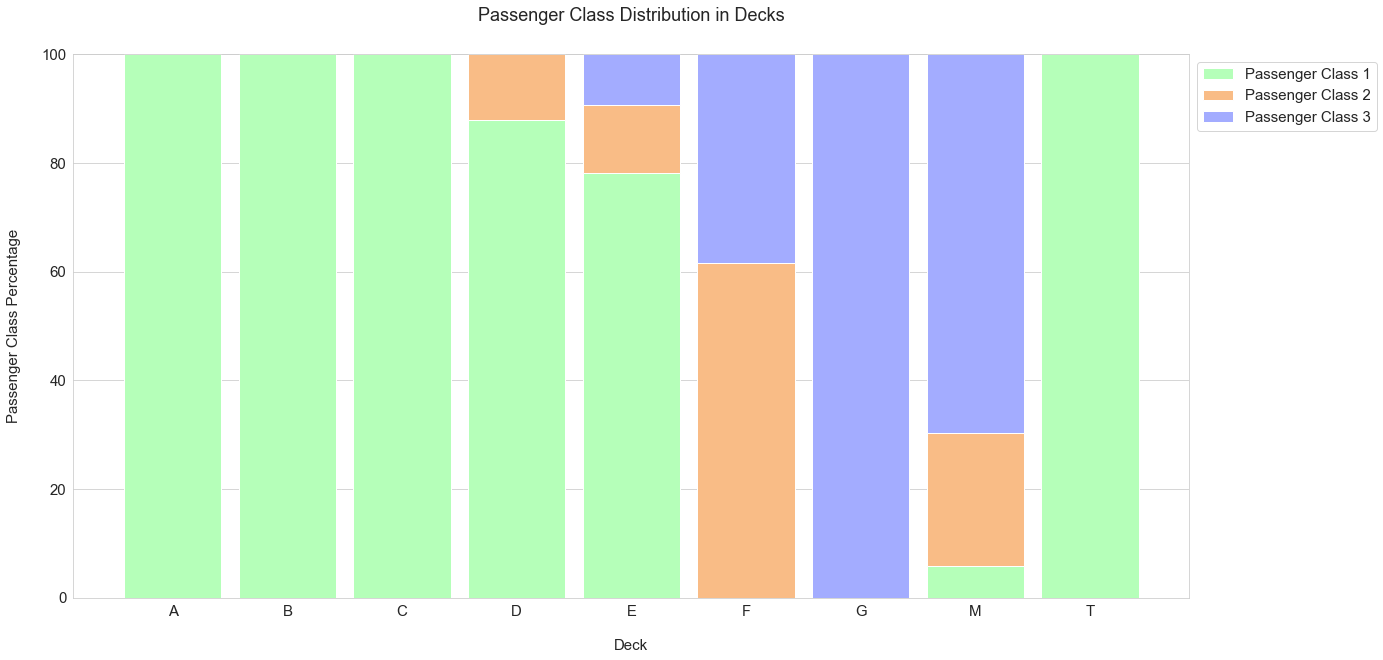

In [10]:
df_train['Deck'] = df_train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

data_train_decks = df_train.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
     
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(data_train_decks)
display_pclass_dist(all_deck_per)

In [11]:
#Transform features
def transf_age(df):
    df['Age'] = df_train[['Age','Pclass','Sex']].apply(impute_age,axis=1)
    df.loc[ df['Age'] <= 10, 'Age'] = 0
    df.loc[(df['Age'] > 10) & (df['Age'] <= 20), 'Age'] = 1
    df.loc[(df['Age'] > 20) & (df['Age'] <= 35), 'Age'] = 2
    df.loc[(df['Age'] > 35) & (df['Age'] <= 50), 'Age'] = 3
    df.loc[(df['Age'] > 50) & (df['Age'] <= 65), 'Age'] = 4
    df.loc[ df['Age'] > 65, 'Age'] = 5 
    return df
def transf_emb(df):
    df['Embarked'] = df['Embarked'].fillna('S')     
    return df
def transf_deck(df):
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df['Deck'] = df['Deck'].replace(['A','B','C','T'], 'ABC')
    df['Deck'] = df['Deck'].replace(['D','E'], 'DE')
    df['Deck'] = df['Deck'].replace(['F','G'], 'FG')
    return df
def transf_title(df):
    df['Title'] = df['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0] 
    df['Title'] = df['Title'].replace(['Miss','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Ms')
    df['Title'] = df['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
    return df
def transf_fam(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FamilySize'] = df['FamilySize'].replace([2,3],'Small')
    df['FamilySize'] = df['FamilySize'].replace([4,5,6,7,8,9,10,11],'Medium')
    return df
def transf_fare(df):
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Fare'] = df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df['Fare'] = df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df['Fare'] = df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df['Fare'] = df.loc[ df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)
    return df
def transf_alone(df):
    df['IsAlone'] = 0
    df.loc[df['FamilySize']==1, 'IsAlone'] = 1
    return df
def transf_wc(df):
    df['IsWomanOrChild'] = ((df.Title == 'Master') | (df.Sex == 'female'))
    return df
def transf_features(df):
    df = transf_age(df)
    df = transf_emb(df)
    df = transf_deck(df)
    df = transf_title(df)
    df = transf_fam(df)
    df = transf_fare(df)
    df = transf_alone(df)
    transf_wc(df)
    return df

df_train = transf_features(df_train)
df_test = transf_features(df_test)


In [12]:
df_test['Title'].value_counts()


Mr                          240
Miss/Ms                      80
Mrs                          72
Master                       21
Dr/Military/Noble/Clergy      5
Name: Title, dtype: int64

In [13]:
#Need to encode non int objects to int by getting dummy variables
def encode_var(df):
    sex = pd.get_dummies(df['Sex'],drop_first=True)
    title = pd.get_dummies(df['Title'],drop_first=True)
    deck = pd.get_dummies(df['Deck'],drop_first = True)
    fam = pd.get_dummies(df['FamilySize'],drop_first = True)
    df = pd.concat([df, sex,title,deck,fam],axis = 1)
    return df

def drop_cols(df):
    df.drop(['Sex','Embarked','Name','Ticket','Cabin','Title','Deck','FamilySize','SibSp','Parch'],axis=1,inplace=True)
    return df

df_train = encode_var(df_train)
df_test = encode_var(df_test)
df_train = drop_cols(df_train)
df_test = drop_cols(df_test)
df_train.head(3)


,PassengerId,Survived,Pclass,Age,Fare,IsAlone,IsWomanOrChild,male,Master,Miss/Ms,Mr,Mrs,DE,FG,M,Medium,Small
0,1,0,3,2.0,3,0,False,1,0,0,1,0,0,0,1,0,1
1,2,1,1,3.0,3,0,True,0,0,0,0,1,0,0,0,0,1
2,3,1,3,2.0,3,1,True,0,0,1,0,0,0,0,1,0,0


In [14]:
X_all = df_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X_all, 
                                                    y_all, test_size=0.30, 
                                                    random_state=101)

In [15]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
clf = RandomForestClassifier()
#clf = LogisticRegression()
#clf = SVC()

parameters = {'n_estimators': [100],
 'min_samples_split': [14],
 'min_samples_leaf': [3],
 'max_features': [5],
 'max_depth': [140],
 'bootstrap': [True]}


acc_scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(clf ,parameters,scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
clf = grid_obj.best_estimator_
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

C:\Users\Brian\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8283582089552238


In [16]:
def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all,y_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.8333333333333334
Fold 2 accuracy: 0.8539325842696629
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.8314606741573034
Fold 5 accuracy: 0.8426966292134831
Fold 6 accuracy: 0.797752808988764
Fold 7 accuracy: 0.7865168539325843
Fold 8 accuracy: 0.797752808988764
Fold 9 accuracy: 0.8876404494382022
Fold 10 accuracy: 0.8314606741573034
Mean Accuracy: 0.8249063670411985


In [17]:
df_train.head()

,PassengerId,Survived,Pclass,Age,Fare,IsAlone,IsWomanOrChild,male,Master,Miss/Ms,Mr,Mrs,DE,FG,M,Medium,Small
0,1,0,3,2.0,3,0,False,1,0,0,1,0,0,0,1,0,1
1,2,1,1,3.0,3,0,True,0,0,0,0,1,0,0,0,0,1
2,3,1,3,2.0,3,1,True,0,0,1,0,0,0,0,1,0,0
3,4,1,1,2.0,3,0,True,0,0,0,0,1,0,0,0,0,1
4,5,0,3,2.0,3,1,False,1,0,0,1,0,0,0,1,0,0


In [18]:
ids = df_test['PassengerId']
predictions = clf.predict(df_test.drop('PassengerId', axis=1))

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions})
output.to_csv('titanic-predictions10.csv', index = False)
output.head(4)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
